In [1]:
import pandas as pd
import sqlite3
import random
import requests

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from io import BytesIO

In [2]:
conn = sqlite3.connect('data/sqlite/nfl_data.sqlite')

In [3]:
teams_df = pd.read_sql('SELECT * FROM teams', conn).set_index('abbreviation')

In [4]:
games_df = pd.read_sql('SELECT * FROM games', conn).set_index('gameId')

In [5]:
plays_df = pd.read_sql('SELECT * FROM plays', conn).set_index('play_uuid')

In [6]:
# (GITHUB COLAB AI) 
# prompt: load all CSV files with a name like "tracking_week_" into a tracking_df dataframe
import glob
tracking_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-2024/*week*.csv')))
# generate same Play-UUID for frame lookup
tracking_df['play_uuid'] = tracking_df['gameId'].astype(str) + '.' + tracking_df['playId'].astype(str)
tracking_df['club'] = tracking_df['club'].replace('LA', 'LAR').replace('WAS', 'WSH')

In [7]:
# tracking_df = pd.read_sql('SELECT * FROM tracking', conn)

In [8]:
snap_formations_df = pd.read_sql('SELECT * FROM snap_formations', conn).set_index('play_uuid')
snap_formations_df.head()

,x0,y0,s0,a0,dis0,o0,dir0,x1,y1,s1,...,yardsToGo,preSnapHomeScore,preSnapVisitorScore,offenseFormation,defendersInTheBox,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,down
play_uuid,,,,,,,,,,,,,,,,,,,,,
2022090800.101,73.13,27.67,0.10,1.14,0.02,273.97,348.75,67.35,29.96,0.07,...,10,0,0,I_FORM,6.0,0.399819,0.600181,-0.014850,0.014850,1
2022090800.1187,71.72,29.54,0.05,0.85,0.01,272.46,55.53,69.25,24.99,0.14,...,10,0,10,SINGLEBACK,6.0,0.207237,0.792763,0.006345,-0.006345,1
2022090800.1254,59.81,23.63,0.00,0.00,0.00,272.98,143.12,42.18,36.75,0.65,...,10,0,10,PISTOL,6.0,0.227212,0.772788,0.008701,-0.008701,1
2022090800.1385,36.64,29.50,0.08,0.88,0.01,273.91,130.33,34.44,33.93,0.49,...,10,0,10,SINGLEBACK,6.0,0.235201,0.764799,0.027923,-0.027923,1
2022090800.1406,18.65,23.35,0.25,1.67,0.02,278.66,52.44,16.13,28.06,0.40,...,7,0,10,SINGLEBACK,6.0,0.263124,0.736876,0.000100,-0.000100,1


In [9]:
# Filter tracking_df for the Ball Snap Frames
ball_snap_df = tracking_df.loc[(tracking_df['event'] == 'ball_snap')] #| (tracking_df['event'] == 'autoevent_ballsnap')]
ball_snap_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [10]:
position_counts = ball_snap_df[['play_uuid', 'nflId']].groupby('play_uuid').count()
snap_ids = position_counts.loc[(position_counts['nflId'] == 22)].index
snap_ids

Index(['2022090800.101', '2022090800.1187', '2022090800.1254',
       '2022090800.1385', '2022090800.1406', '2022090800.146',
       '2022090800.1736', '2022090800.191', '2022090800.1946',
       '2022090800.2043',
       ...
       '2022110700.3787', '2022110700.403', '2022110700.443', '2022110700.493',
       '2022110700.546', '2022110700.612', '2022110700.670', '2022110700.80',
       '2022110700.929', '2022110700.950'],
      dtype='object', name='play_uuid', length=6323)

In [12]:
snap_ids = [snap_id for snap_id in snap_ids if snap_id in plays_df.index]

In [13]:
# Create a DF of the plays with all-22 Frames available
all_22_plays_df = plays_df.loc[snap_ids]
all_22_plays_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,week,cumulativeOverall_O,cumulativeOverall_D,cumulativeOverall_P,cumulativePerFormation_O,cumulativePerFormation_D,cumulativePerFormation_P,cumulativePerBoxCt_O,cumulativePerBoxCt_D,cumulativePerBoxCt_P
play_uuid,,,,,,,,,,,,,,,,,,,,,
2022090800.101,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LAR,...,1,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000
2022090800.1187,2022090800,1187,47853,Darrell Henderson,(8:48) D.Henderson right tackle to LA 44 for 4...,2,1,10,LAR,BUF,...,1,0.200000,0.800000,0.000000,0.000000,1.000000,0.000000,0.142857,0.857143,0.000000
2022090800.1254,2022090800,1254,46830,Brandon Powell,(7:20) (Shotgun) B.Powell left tackle to BUF 4...,2,1,10,LAR,BUF,...,1,0.250000,0.750000,0.000000,0.000000,0.000000,0.000000,0.222222,0.777778,0.000000
2022090800.1385,2022090800,1385,47853,Darrell Henderson,(4:14) D.Henderson left end to BUF 7 for 18 ya...,2,1,10,LAR,BUF,...,1,0.250000,0.750000,0.000000,0.000000,1.000000,0.000000,0.181818,0.818182,0.000000
2022090800.1406,2022090800,1406,47853,Darrell Henderson,(3:42) D.Henderson up the middle to BUF 4 for ...,2,1,7,LAR,BUF,...,1,0.294118,0.705882,0.166667,0.166667,0.833333,0.333333,0.250000,0.750000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022110700.612,2022110700,612,47896,Justice Hill,(3:44) (Shotgun) J.Hill left end to NO 40 for ...,1,1,10,BAL,NO,...,9,0.392857,0.653409,0.200000,0.250000,0.583333,0.071429,0.393939,0.643836,0.400000
2022110700.670,2022110700,670,46101,Lamar Jackson,(2:09) (Shotgun) L.Jackson left end to NO 24 f...,1,3,1,BAL,NO,...,9,0.390710,0.655367,0.426471,0.247863,0.594595,0.333333,0.410714,0.739496,0.461538
2022110700.80,2022110700,80,44879,Alvin Kamara,(14:24) (Shotgun) A.Kamara right tackle to NO ...,1,1,10,NO,BAL,...,9,0.388747,0.588556,0.248000,0.485714,0.540670,0.333333,0.328571,0.655556,0.196078


In [14]:
# filter for tracking frames from the all-22 df and the ball snap event.
# These will all be 22 players and the ball for each play_uuid
all_22_frames_df = ball_snap_df.loc[(ball_snap_df['play_uuid'].isin(snap_ids))]
all_22_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [15]:
# Select a random play from the all-22 plays
random_play =  random.randint(0, len(all_22_plays_df))
# Select the play record
play = all_22_plays_df.iloc[random_play]
random_id = play.name
play

gameId                                                                     2022091809
playId                                                                            122
ballCarrierId                                                                   43293
ballCarrierDisplayName                                                Ezekiel Elliott
playDescription                     (13:15) E.Elliott left tackle to DAL 44 for 7 ...
quarter                                                                             1
down                                                                                2
yardsToGo                                                                           9
possessionTeam                                                                    DAL
defensiveTeam                                                                     CIN
yardlineSide                                                                      DAL
yardlineNumber                                        

In [16]:
play_frames = tracking_df.loc[((tracking_df['gameId'] == play['gameId']) & (tracking_df['playId'] == play['playId']))]
play_frames

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
841680,2022091809,122,41242.0,Zack Martin,1,2022-09-18 16:28:07.200000,70.0,DAL,left,74.210000,31.320000,0.00,0.00,0.00,238.49,140.10,NaN,2022091809.122
841681,2022091809,122,41242.0,Zack Martin,2,2022-09-18 16:28:07.299999,70.0,DAL,left,74.210000,31.320000,0.00,0.00,0.00,234.22,132.31,NaN,2022091809.122
841682,2022091809,122,41242.0,Zack Martin,3,2022-09-18 16:28:07.400000,70.0,DAL,left,74.210000,31.320000,0.00,0.00,0.00,232.76,123.40,NaN,2022091809.122
841683,2022091809,122,41242.0,Zack Martin,4,2022-09-18 16:28:07.500000,70.0,DAL,left,74.210000,31.320000,0.00,0.06,0.01,228.46,131.29,NaN,2022091809.122
841684,2022091809,122,41242.0,Zack Martin,5,2022-09-18 16:28:07.599999,70.0,DAL,left,74.200000,31.300000,0.05,0.55,0.02,225.34,186.74,NaN,2022091809.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842871,2022091809,122,NaN,football,48,2022-09-18 16:28:11.900000,NaN,football,left,67.279999,22.170000,2.04,3.14,0.22,NaN,NaN,tackle,2022091809.122
842872,2022091809,122,NaN,football,49,2022-09-18 16:28:12.000000,NaN,football,left,67.209999,22.100000,1.54,3.23,0.10,NaN,NaN,NaN,2022091809.122
842873,2022091809,122,NaN,football,50,2022-09-18 16:28:12.099999,NaN,football,left,67.099998,22.010000,1.23,2.95,0.14,NaN,NaN,NaN,2022091809.122
842874,2022091809,122,NaN,football,51,2022-09-18 16:28:12.200000,NaN,football,left,67.080002,21.990000,0.88,2.33,0.03,NaN,NaN,NaN,2022091809.122


In [17]:
len(tracking_df['nflId'].unique())

1684

In [18]:
# Select the tracking player positions from ball-snap for this play
play_frame = ball_snap_df.loc[(ball_snap_df['play_uuid'] == play.name)]
play_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
841685,2022091809,122,41242.0,Zack Martin,6,2022-09-18 16:28:07.700000,70.0,DAL,left,74.20,31.27,0.25,1.47,0.03,251.66,186.36,ball_snap,2022091809.122
841737,2022091809,122,43293.0,Ezekiel Elliott,6,2022-09-18 16:28:07.700000,21.0,DAL,left,80.37,29.75,0.00,0.00,0.00,263.10,256.49,ball_snap,2022091809.122
841789,2022091809,122,43299.0,Eli Apple,6,2022-09-18 16:28:07.700000,20.0,CIN,left,67.57,36.16,0.12,1.26,0.03,79.44,229.58,ball_snap,2022091809.122
841841,2022091809,122,43350.0,Vonn Bell,6,2022-09-18 16:28:07.700000,24.0,CIN,left,71.13,18.13,0.06,0.68,0.01,76.28,273.95,ball_snap,2022091809.122
841893,2022091809,122,43455.0,D.J. Reader,6,2022-09-18 16:28:07.700000,98.0,CIN,left,72.23,29.79,0.27,1.51,0.03,74.56,160.27,ball_snap,2022091809.122
841945,2022091809,122,44872.0,Chidobe Awuzie,6,2022-09-18 16:28:07.700000,22.0,CIN,left,72.17,9.91,0.05,0.05,0.07,58.70,252.69,ball_snap,2022091809.122
841997,2022091809,122,44915.0,Trey Hendrickson,6,2022-09-18 16:28:07.700000,91.0,CIN,left,72.58,23.66,0.00,0.00,0.01,51.86,68.25,ball_snap,2022091809.122
842049,2022091809,122,45052.0,Noah Brown,6,2022-09-18 16:28:07.700000,85.0,DAL,left,75.03,17.82,0.10,0.06,0.02,263.74,292.82,ball_snap,2022091809.122
842101,2022091809,122,45226.0,Josh Tupou,6,2022-09-18 16:28:07.700000,68.0,CIN,left,72.28,27.65,0.02,0.76,0.01,70.84,156.63,ball_snap,2022091809.122
842153,2022091809,122,45536.0,Cooper Rush,6,2022-09-18 16:28:07.700000,10.0,DAL,left,74.57,29.70,0.00,0.00,0.00,256.11,251.06,ball_snap,2022091809.122


In [19]:
last_frame_id = tracking_df.loc[(tracking_df['play_uuid'] == play.name)]['frameId'].max()
last_frame = tracking_df.loc[((tracking_df['play_uuid'] == play.name) & (tracking_df['frameId'] == last_frame_id))]
last_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
841731,2022091809,122,41242.0,Zack Martin,52,2022-09-18 16:28:12.299999,70.0,DAL,left,66.530000,21.290000,1.26,2.12,0.13,250.88,223.89,NaN,2022091809.122
841783,2022091809,122,43293.0,Ezekiel Elliott,52,2022-09-18 16:28:12.299999,21.0,DAL,left,66.990000,21.930000,0.65,1.85,0.08,104.84,230.20,NaN,2022091809.122
841835,2022091809,122,43299.0,Eli Apple,52,2022-09-18 16:28:12.299999,20.0,CIN,left,64.140000,21.700000,2.11,2.84,0.22,94.57,201.48,NaN,2022091809.122
841887,2022091809,122,43350.0,Vonn Bell,52,2022-09-18 16:28:12.299999,24.0,CIN,left,71.080000,10.430000,2.62,0.75,0.26,329.61,197.06,NaN,2022091809.122
841939,2022091809,122,43455.0,D.J. Reader,52,2022-09-18 16:28:12.299999,98.0,CIN,left,72.570000,23.430000,0.71,0.85,0.07,345.90,280.20,NaN,2022091809.122
841991,2022091809,122,44872.0,Chidobe Awuzie,52,2022-09-18 16:28:12.299999,22.0,CIN,left,62.330000,17.390000,3.03,1.76,0.31,157.04,349.61,NaN,2022091809.122
842043,2022091809,122,44915.0,Trey Hendrickson,52,2022-09-18 16:28:12.299999,91.0,CIN,left,72.250000,25.470000,1.92,1.05,0.20,234.78,250.54,NaN,2022091809.122
842095,2022091809,122,45052.0,Noah Brown,52,2022-09-18 16:28:12.299999,85.0,DAL,left,71.150000,11.470000,2.49,2.35,0.24,235.87,199.31,NaN,2022091809.122
842147,2022091809,122,45226.0,Josh Tupou,52,2022-09-18 16:28:12.299999,68.0,CIN,left,71.460000,21.610000,2.21,0.29,0.22,291.64,272.89,NaN,2022091809.122
842199,2022091809,122,45536.0,Cooper Rush,52,2022-09-18 16:28:12.299999,10.0,DAL,left,80.890000,34.830000,2.73,2.41,0.27,247.48,273.74,NaN,2022091809.122


In [20]:
# Select the game for this play
game = games_df.loc[play['gameId']]
game

season                     2022
week                          2
gameDate             09/18/2022
gameTimeEastern        16:25:00
homeTeamAbbr                DAL
visitorTeamAbbr             CIN
homeFinalScore               20
visitorFinalScore            17
Name: 2022091809, dtype: object

In [21]:
# Load the Home team logo from the ESPN API 
response = requests.get(teams_df.loc[game['homeTeamAbbr']]['logo'])
home_img = Image.open(BytesIO(response.content))
# Load the away team logo from the ESPN API
response = requests.get(teams_df.loc[game['visitorTeamAbbr']]['logo'])
away_img = Image.open(BytesIO(response.content))

In [22]:
# Initialize team colors from the ESPN API
teams = play_frame['club'].unique()
colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['color']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['color']), 
          'football': 'brown'}
alt_colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['alternateColor']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['alternateColor']), 
          'football': 'yellow'}

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_44083/4208403530.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']


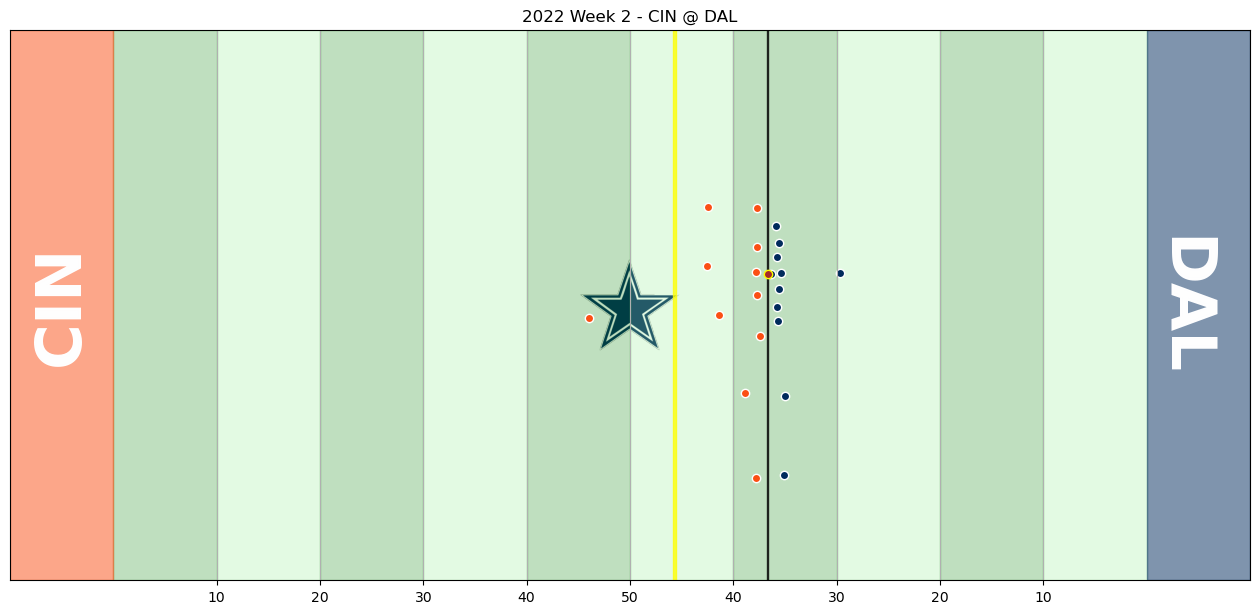

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_44083/4208403530.py:124: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']


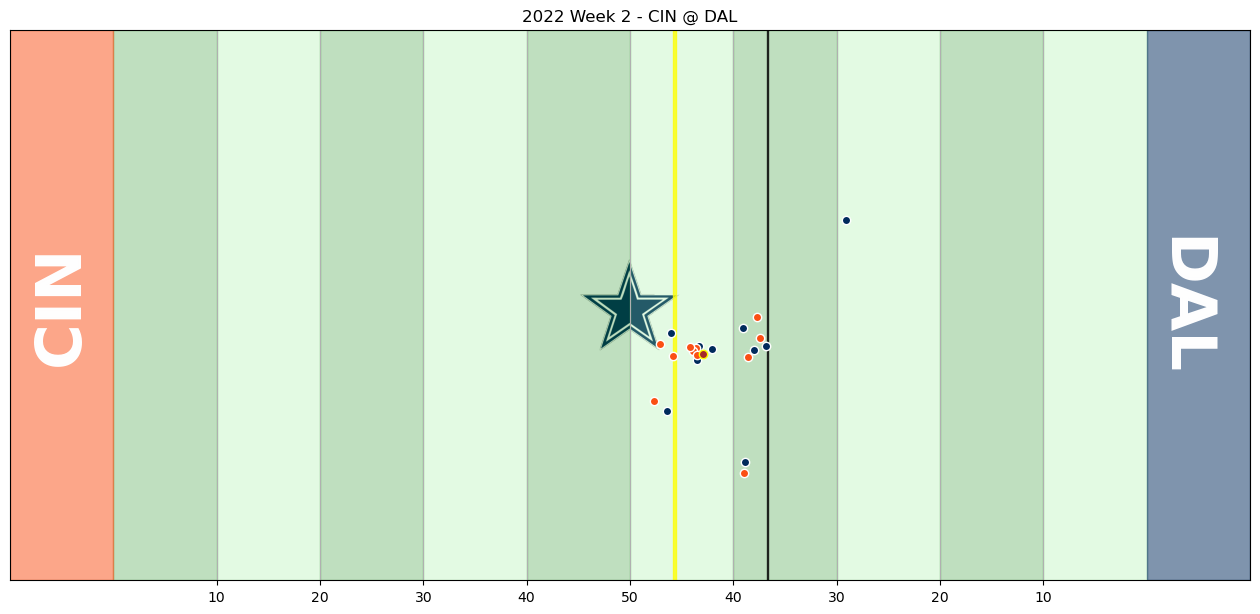

In [23]:
# Build Field and Play formation plot with Matplotlib

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

